#Features evaluation
This notebook is designed to evaluate the effect of using different features for audio classification.

We aim to do a straight classification on a dataset of 4 second audio snippets, each with a ground truth class label, e.g. 'bird' or 'fox'. 

We use a random forest for all the comparisons; other classifiers are available.

Running this entire notebook takes about 10 minutes on an 8-core desktop. A good speedup could be achieved by parallelising the feature computation, which currently takes about four minutes. The training and testing of the models takes most of the time, and this is already multi-core.

## Specific dependencies
- sklearn 0.16 or above (for class weighting in random forest)
- mfcc features (from https://github.com/jameslyons/python_speech_features)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import csv
import collections

import scipy.io.wavfile
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency

# mfcc features from: https://github.com/jameslyons/python_speech_features
from features import mfcc

In [2]:
# this sets where the data is stored
base_path = '/home/michael/projects/engaged_hackathon_data/cropped_audio/'

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01
    }

# we won't bother training OR testing on classes with fewer data than this number:
minimum_class_count = 10

## Counting the number of each class in the dataset
Here we loop through the dataset once to get the count of each class. See also the `dataset_overview` notebook for a proper analysis of class frequency in the dataset.

In [3]:
filelist = csv.reader(open(base_path + 'below12kHz_cropped_label.txt'))

# loop over each wav file
Y = []
for f in filelist:
    wavpath, start_time, wav_class, _ = f
    Y.append(wav_class.lower().strip())

# Make use of the collections counter class
class_counts = collections.Counter(Y)

## Loading data and computing different types of features
For each wav file in the dataset, compute a few different types of features. Instead of loading all the data into memory first, each wav file is loaded one at a time. This reduces the memory load at the expense of repeating I/O operations if the notebook is run multiple times.

TODO - make parrallel, for speed gains

In [4]:
# list of class labels
Y = []  

# Features. We maintain a separate list for each feature
X_mfcc = []
X_resized_spectrogram = []
X_max_bins = []
# X_frequency_stats = []

filelist = csv.reader(open(base_path + 'below12kHz_cropped_label.txt'))

# loop over each wav file
for count, f in enumerate(filelist):
    
    wavpath, start_time, wav_class, _ = f
    
    # don't bother with this example if there aren't enough of them in the dataset
    if class_counts[wav_class.lower().strip()] < minimum_class_count:
        continue
    
    # add to the list of classes
    Y.append(wav_class.lower().strip())
    
    # load in sound file and convert to spectogram  
    sr, wav = scipy.io.wavfile.read(base_path + wavpath)  
    spec = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    
    # ---------------------------------------------
    # FEATURE COMPUTATION
    
    # Small spectrogram: Simply make the spectrogram small, each pixel is a feature bin
    X_resized_spectrogram.append(engaged_features.small_spectrogram(spec))
    
    # Max bins: Find the maximum frequency at each time step
    X_max_bins.append(engaged_features.max_bins(spec))
    
    # MFCC features
    mfcc_feats = mfcc(wav, sr, ceplifter=0, preemph=0, numcep=13)
    accumulated_features = np.hstack([mfcc_feats.mean(0), mfcc_feats.var(0), mfcc_feats.max(0)])
    X_mfcc.append(accumulated_features)
    
    # ---------------------------------------------
   
    # Keep us updated on progress
    if count % 100 == 0:
        print count, 
        
    # Uncomment this to do a 'small' run with only a few examples
#     if count >= 500:
#         break

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700


/home/michael/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


## Combining features into Numpy arrays

In [5]:
# combine the lists of features into numpy arrays of features
X = {}
X['mfcc'] = np.vstack(X_mfcc)
X['resized_spectrogram'] = np.vstack(X_resized_spectrogram)
X['max_bins'] = np.vstack(X_max_bins)

for name, x in X.iteritems():
    print "Feature matrix \"%s\" has shape (%d, %d)" % (name, x.shape[0], x.shape[1])

Feature matrix "resized_spectrogram" has shape (8737, 100)
Feature matrix "max_bins" has shape (8737, 80)
Feature matrix "mfcc" has shape (8737, 39)


## Training and testing the models for each feature type
The aim is to see how good each set of features is for classification.
We run a different experiment for each set of features. We also run an experiment which combines all the features together.
To remove dependancy on the train-test split used, we repeat this for 50 different train test splits.

To account for imbalance in the training set, we use the `class_weight` functionality of `sklearn.ensemble.RandomForestClassifier`. This was introduced in sklearn 0.16.


**TODO - we should really split by file not just by instance**

In [6]:
# setting up a dictionary of experiments to run
# keys are names of this experiment
# values are a list of all the features to test on for this experiment
experiments = {
    'mfcc': ['mfcc'],
    'resized_spectrogram': ['resized_spectrogram'],
    'max_bins': ['max_bins'],
    'all': ['mfcc', 'resized_spectrogram', 'max_bins']
    }

# set up a dictionary to store the results.
# Using DefaultDict: https://docs.python.org/2/library/collections.html#defaultdict-examples
results = collections.defaultdict(list)

# we will repeat the experiment for multiple train/test splits, and ultimately average over them
for random_seed in range(5):
    
    print "Seed", random_seed,
    
    # TODO - we should really split by file not just by instance
    train_idxs, test_idxs = train_test_split(range(len(Y)))
    
    Y_train = [Y[idx] for idx in train_idxs]
    Y_test = [Y[idx] for idx in test_idxs]
    
    # Set a baseline where all the test set is classified as bird
    all_bird = {'Y_pred': ['bird'] * len(Y_test), 'Y_test': Y_test}
    results['classify_all_as_bird'].append(all_bird)
            
    # loop over each experiment
    for experiment_name, feature_list in experiments.iteritems():

        # concatenating all the feature vectors for this experiment together
        X_np = np.hstack([X[feat_name] for feat_name in feature_list])
        
        X_train = X_np[train_idxs]
        X_test = X_np[test_idxs]

        # training a classifier on these features and then testing on test set
        rf = RandomForestClassifier(n_estimators=100,     # 100 trees in forest
                                    max_depth=20,         # chosen this fairly randomly
                                    class_weight='auto',  # to help account for imbalance in training set
                                    n_jobs=-1,            # to make parallel
                                    max_features=None)    # at each node, check *all* the features for a good split
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)
                
        # adding this result to the results dictionary
        this_result = {'Y_test': Y_test, 'Y_pred': list(Y_pred)}
        results[experiment_name].append(this_result)

Seed 0 Seed 1 Seed 2 Seed 3 Seed 4


## Evaluating accuracy of approaches
We report two accuracy measures:

1. **Unnormalised accuracy**: This is simply the fraction of the test items which have been correctly labelled. This is simple, but is biased by imbalanced classes. E.g. if 80% of the test dataset are labelled as 'bird', you can achieve 80% accuracy easily simply by labelling everything as 'bird'.

2. **Class-normalised accuracy**: This measure mitigates against these problems by reporting the average accuracy *per-class*. This means that we find the accuracy for all the items with a ground truth label of 'bird', the accuracy for the items with a ground truth label of 'bat', etc. We then average all these scores to find the final number.

Experiment name          Unnormalised accuracy   Normalised accuracy 
----------------------------------------------------------------------
mfcc                     0.728			 0.444
all                      0.680			 0.314
max_bins                 0.620			 0.137
classify_all_as_bird     0.545			 0.050
resized_spectrogram      0.541			 0.074


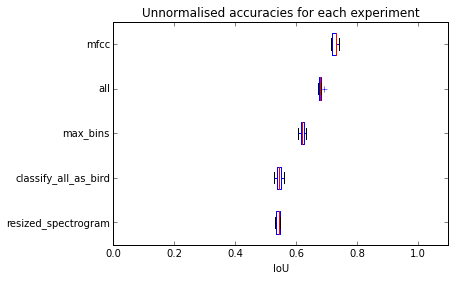

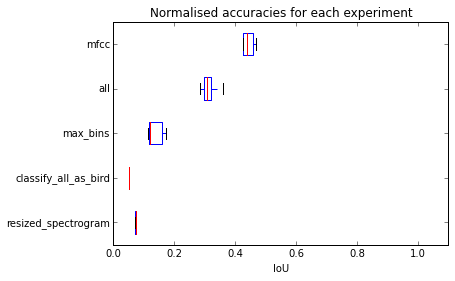

In [7]:
import sklearn.metrics


def unnormalised_accuracy(Y_pred, Y_ground_truth):
    """
    This is simply the fraction of the test data which have been correctly labelled
    """
    return sklearn.metrics.accuracy_score(Y_pred, Y_ground_truth)


def class_normalised_accuracy(Y_pred, Y_ground_truth):
    """
    This is the average fraction of each class in the ground truth examples which were correctly labelled.
    This helps to remove bias caused by large imbalance in class labels in the testing set
    """
    correct_label_count = collections.defaultdict(int)
    total_label_count = collections.defaultdict(int)
    
    # for each prediction, update the number of correct vs total labels
    for y_pred, y_ground_truth in zip(Y_pred, Y_ground_truth):
        
        total_label_count[y_ground_truth] += 1

        if y_pred == y_ground_truth:
            correct_label_count[y_ground_truth] += 1
        
    # compute a final per-class accuracy
    these_accs = []
    for class_name, total_count in total_label_count.iteritems():
        correct_count = correct_label_count[class_name]
        these_accs.append(float(correct_count) / float(total_count))
    
    # return the mean per-class accuracy
    return np.array(these_accs).mean()


accuracies = []

# Find the accuracy of each feature type
for experiment_name, result_list in results.iteritems():
    
    # get a list of all the accuracy results for each train/test split
    unnormalised_acc = [unnormalised_accuracy( result['Y_pred'], result['Y_test']) 
           for result in result_list]

    class_normalised_acc = [class_normalised_accuracy( result['Y_pred'], result['Y_test']) 
           for result in result_list]

    accuracies.append((experiment_name, unnormalised_acc, class_normalised_acc))
    
# sorting the list of accuracies by median accuracy
accuracies = sorted(accuracies, key=lambda x: np.median(np.array(x[1])))

# printing this sorted list
print "Experiment name".ljust(25) + "Unnormalised accuracy".ljust(24) + "Normalised accuracy".ljust(20)
print '-' * 70
for experiment_name, acc1, acc2 in accuracies[::-1]:
    print experiment_name.ljust(25) + '%0.3f\t\t\t %0.3f' % (np.array(acc1).mean(), np.array(acc2).mean())

plt.boxplot([acc[1] for acc in accuracies], 0, 'b+', 0);
plt.xlim(0, 1.1)
plt.xlabel('IoU')
plt.title('Unnormalised accuracies for each experiment')
plt.gca().set_yticklabels([acc[0] for acc in accuracies]);

plt.figure()
plt.boxplot([acc[2] for acc in accuracies], 0, 'b+', 0);
plt.xlim(0, 1.1)
plt.xlabel('IoU')
plt.title('Normalised accuracies for each experiment')
plt.gca().set_yticklabels([acc[0] for acc in accuracies]);

## Confusion matrix
Only plotting for one run of the results.

- Experiment type: `all`, i.e. with all the features used
- Zeroth train/test split

i.e. `results['all'][0]['Y_pred']`

We plot two confusion matrices:

- **Unnormalised**: Standard confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix)
- **Normalised**: Each row normalised to sum to one.

/home/michael/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


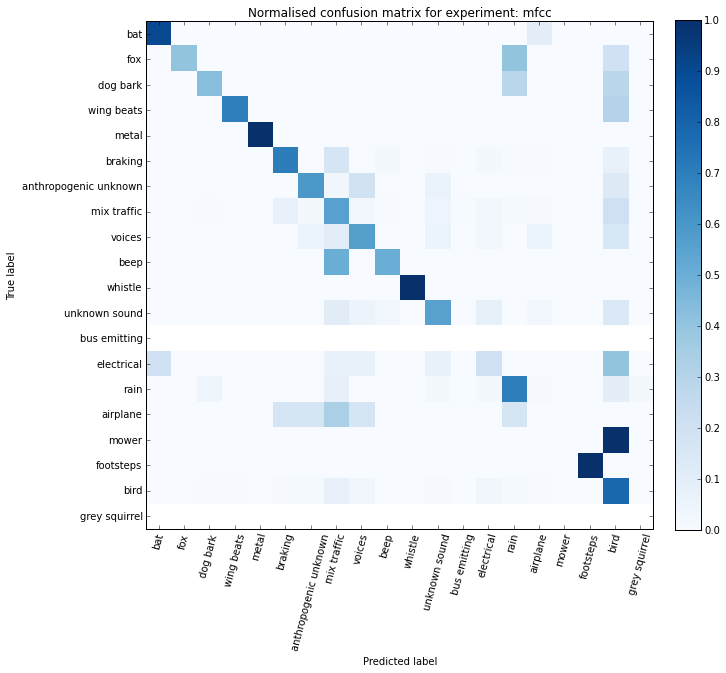

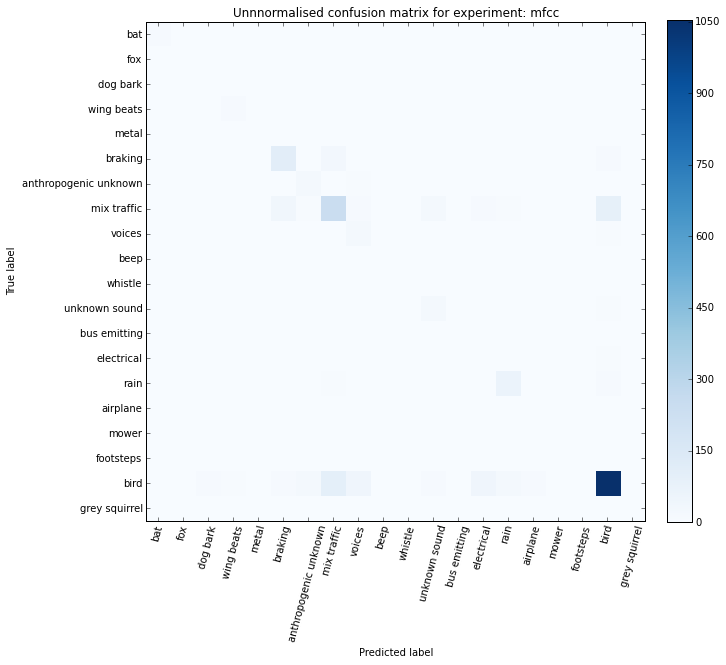

In [8]:
from sklearn.metrics import confusion_matrix

experiment_to_show = 'mfcc'

unique_labels = list(set(Y))

predictions = list(results[experiment_to_show][0]['Y_pred'])
ground_truth = results[experiment_to_show][0]['Y_test']

cm = confusion_matrix(predictions, ground_truth, labels=unique_labels)
cm_normalized = cm.astype('float') / cm.astype('float').sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=75)
    plt.yticks(tick_marks, unique_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm_normalized, 
  title='Normalised confusion matrix for experiment: ' + experiment_to_show + '');


plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, 
  title='Unnnormalised confusion matrix for experiment: ' + experiment_to_show + '');



## Feature importances from the random forest

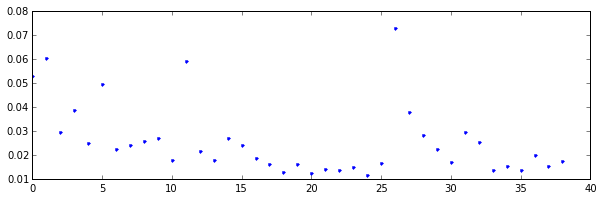

In [9]:
# plotting feature importances for each 
plt.figure(figsize=(10, 3))
plt.plot(rf.feature_importances_, '.')